## Ejercicio teórico

Sea una red neuronal de dos capas, la primera de 3 neuronas y la segunda de 1 con los parámetros inicializados con los siguientes valores:
$$
w^{(1)} =
\begin{pmatrix}
0.1 & -0.5 \\
-0.3 & -0.9 \\
0.8 & 0.02
\end{pmatrix},
b^{(1)} = \begin{pmatrix}
0.1 \\
0.5 \\
0.8
\end{pmatrix},
w^{(2)} =
\begin{pmatrix}
-0.4 & 0.2 & -0.5
\end{pmatrix},
b^{(2)} = 0.7
$$

y donde cada capa calcula su salida vía

$$
y^{(i)} = \sigma (w^{(i)} \cdot x^{(i)}+b^{(i)})
$$

donde $\sigma (z) = \frac{1}{1+e^{-z}}$ es la función sigmoidea .

\\
Dada la observación $x=\begin{pmatrix}
1.8 \\
-3.4
\end{pmatrix}$, $y=5$ y la función de costo $J(\theta)=\frac{1}{2}(\hat{y}_\theta-y)^2$, calcular las derivadas de J respecto de cada parámetro $w^{(1)}$, $w^{(2)}$, $b^{(1)}$, $b^{(2)}$.

*Nota: Con una sigmoidea a la salida jamás va a poder estimar el 5 "pedido", pero eso no afecta al mecanismo de backpropagation!*

In [93]:
import numpy as np

In [94]:
class Layer(object):
  def __init__(self, n_in, n_out, non_linearity_class, optimizer_factory, rng, w_init=None, b_init=None):
    self.activation = non_linearity_class()
    self.optim = optimizer_factory()
    #self.w = rng.standard_normal(size=(n_out, n_in))  * 0.1 # W shape is (n_out,n_in)
    #self.b = rng.uniform(size=(n_out, 1))                   # b shape is (n_out, 1)
    # Valores de peso y bias precalculados
    self.w = w_init if w_init is not None else rng.standard_normal(size=(n_out, n_in)) * 0.1
    self.b = b_init if b_init is not None else rng.uniform(size=(n_out, 1))
    self.last_output = None
    self.last_input = None

  def forward(self, X):
    self.last_input = X
    z = self.w @ X + self.b
    self.last_output = self.activation.f(z)
    print("--------------------------")
    print("Forward por capa z:")
    print(z)
    print("Despues de la f de activación:")
    print(self.last_output)
    print("--------------------------")
    return self.last_output

  def backwards(self, dY):
    dz = dY * self.activation.df()
    dW = dz @ self.last_input.T
    db = np.sum(dz, axis=1, keepdims=True)
    dX = self.w.T @ dz
    self.w, self.b = self.optim.update(self.w, self.b, dW, db)

    # Mostrar derivadas parciales
    print("--------------------------")
    print("Derivadas parciales respecto a W:")
    print(dW)
    print("Derivadas parciales respecto a b:")
    print("--------------------------")
    print(db)
    return dX

In [95]:
class MLP(object):
  def __init__(self, dims, optimizer_factory, non_linearities, input_dim, rng_seed = None, precalc_weights=None, precalc_biases=None):
    # check lengths
    if len(dims) != len(non_linearities):
      raise ValueError("dims' and Non_linearities' lengths do not match")
    # initialize RNG
    rng = np.random.default_rng(rng_seed)
    # construct a list of Layers with matching dimension and non-linear activation function
    in_dims = [input_dim] + dims[:-1]
    #self.layers = [Layer(n_in, n_out, non_linearity, optimizer_factory, rng)
    #                for n_in,n_out,non_linearity in zip(in_dims,dims, non_linearities)]
    self.layers = [Layer(n_in, n_out, non_linearity, optimizer_factory, rng, w_init, b_init)
                    for n_in, n_out, non_linearity, w_init, b_init 
                    in zip(in_dims, dims, non_linearities, precalc_weights, precalc_biases)]


  def predict(self, X):
    # X can be interpreted as the output of a previous layer
    prediction = X
    # sequentially apply forward pass
    for layer in self.layers:
      prediction = layer.forward(prediction)
    return prediction

  def update(self, cost_gradient):
    # cost gradient is the cost derivative wrt last layer
    dY = cost_gradient
    # sequentially apply backwards update, in reversed order
    for layer in reversed(self.layers):
      dY = layer.backwards(dY)

  def __repr__(self):
    # super hardcoded
    return "MLP with layer sizes: "+ "-".join(str(layer.b.shape[0]) for layer in self.layers)

In [96]:
class Optimizer(object):
  def update(self, W, b, dW, db):
    raise NotImplementedError("optimizer update rule not implemented")

class VGD(Optimizer):
  def __init__(self, learning_rate):
    self.lr = learning_rate
    
  def update(self, W_old, b_old, dW, db):
    # vanilla GD: theta_t+1 = theta_t - alpha * gradient
    W_new = W_old - self.lr * dW
    b_new = b_old - self.lr * db
    return W_new, b_new

def factory_VGD(lr):
  return lambda : VGD(lr)

In [97]:
class NonLinearity(object):
  def __init__(self):
    self.last_z = None
  def f(self, z):
    raise NotImplementedError("function evaluation not implemented")
  def df(self):
    raise NotImplementedError("function derivative not implemented")
  
class Sigmoid(NonLinearity):
  def __init__(self):
    super().__init__()

  def f(self, z):
    self.last_z = z
    return 1 / (1 + np.exp(-z))

  def df(self):
    return np.exp(-self.last_z) / (1 + np.exp(-self.last_z))**2


In [98]:

lr = 0.001
rng_seed = 6543

# Pesos y sesgos precalculados para cada capa
precalc_weights = [
    np.array([[0.1, -0.5], [-0.3, -0.9], [0.8, 0.02]]),  # Pesos para la primera capa (3x2)
    np.array([[-0.4, 0.2, -0.5]])                        # Pesos para la segunda capa (1x3)
]
precalc_biases = [
    np.array([[0.1], [0.5], [0.8]]),  # Bias para la primera capa (3x1)
    np.array([[0.7]])                 # Bias para la segunda capa (1x1)
]

# Configuración del MLP:
dims = [3, 1]  # 3 neuronas en la primera capa, 1 neurona en la segunda
input_dim = 2  # 2 entradas (dimensión de entrada)
optimizer_factory = lambda: VGD(learning_rate=lr) #No se usa porque el modelo esta pre entrenado
non_linearities = [Sigmoid, Sigmoid]  # Activaciones sigmoides para ambas capas

# Crear la MLP con pesos y sesgos precalculados
mlp = MLP(dims, optimizer_factory, non_linearities, input_dim, precalc_weights=precalc_weights, precalc_biases=precalc_biases)

# Input de ejemplo (2 características de entrada)
X = np.array([[1.8], [-3.4]])  # Tamaño del input (2x1)

# Predecir con el MLP
print("Forward de entrada a dalida")
output = mlp.predict(X)
print("--------------------------")
print("Salida: ",output)
print("--------------------------")



Forward de entrada a dalida
--------------------------
Forward por capa z:
[[1.98 ]
 [3.02 ]
 [2.172]]
Despues de la f de activación:
[[0.87868116]
 [0.95346953]
 [0.89770677]]
--------------------------
--------------------------
Forward por capa z:
[[0.09036805]]
Despues de la f de activación:
[[0.52257665]]
--------------------------
--------------------------
Salida:  [[0.52257665]]
--------------------------


In [99]:
print("Backprop de salida a entrada")
y_true = 5
error = 1/2 * (output - y_true)**2
print("Error cuadratico medio: ", error)
mlp.update(output - y_true)

Backprop de salida a entrada
Error cuadratico medio:  [[10.02365992]]
--------------------------
Derivadas parciales respecto a W:
[[-0.98155159 -1.0650957  -1.0028046 ]]
Derivadas parciales respecto a b:
--------------------------
[[-1.11707367]]
--------------------------
Derivadas parciales respecto a W:
[[ 0.0857381  -0.16194975]
 [-0.01784139  0.0337004 ]
 [ 0.09232211 -0.1743862 ]]
Derivadas parciales respecto a b:
--------------------------
[[ 0.04763228]
 [-0.00991188]
 [ 0.05129006]]


In [100]:
from graphviz import Digraph
import numpy as np

def matrix_to_text(matrix):
    """Convierte una matriz numpy en una cadena de texto legible."""
    text_matrix = "\n["
    for row in matrix:
        text_matrix +=  ", ".join(f"{v:.2f}" for v in row) + "\n"
    text_matrix = text_matrix.rstrip("\n")
    text_matrix += "]"
    return text_matrix

def generate_mlp_graph(mlp):
    dot = Digraph()
    dot.attr(rankdir='LR')  # Configurar la dirección del grafo de izquierda a derecha

    # Crear el nodo de entrada X
    dot.node("X", "Input X")

    # Iterar a través de las capas de la red
    for i, layer in enumerate(mlp.layers):
        input_size = layer.w.shape[1]
        output_size = layer.w.shape[0]
        activation_name = layer.activation.__class__.__name__

        # Convertir los pesos y sesgos en un texto legible
        weights_text = matrix_to_text(layer.w)
        bias_text = matrix_to_text(layer.b)

        # Crear nodos para la capa actual con matrices en texto legible
        dot.node(f"Layer {i+1} input", f"Layer {i+1} input ({input_size})")
        dot.node(f"Layer {i+1} output", 
                 f"Layer {i+1} output ({output_size})\nActivation: {activation_name}\nWeights {layer.w.shape[0]}x{layer.w.shape[1]}: {weights_text}\nBias {layer.b.shape[0]}x{layer.b.shape[1]}: {bias_text}")

        # Conectar la entrada con la salida de la misma capa
        dot.edge(f"Layer {i+1} input", f"Layer {i+1} output", label=f"Layer {i+1}")

        # Conectar la salida de la capa anterior con la entrada de la actual
        if i > 0:
            dot.edge(f"Layer {i} output", f"Layer {i+1} input")
        else:
            # Conectar el nodo de entrada X con la primera capa
            dot.edge("X", f"Layer {i+1} input")

    # Crear el nodo de salida y_hat para la predicción
    dot.node("y_hat", "Predicted Output y_hat")
    dot.edge(f"Layer {len(mlp.layers)} output", "y_hat")

    # Crear el nodo de salida verdadera y
    dot.node("y_true", "True Output y")

    # Crear el nodo de la función de pérdida que conecta y_hat y y_true
    dot.node("Loss", "Loss Function")
    dot.edge("y_hat", "Loss", label="y_hat")
    dot.edge("y_true", "Loss", label="y_true")

    return dot

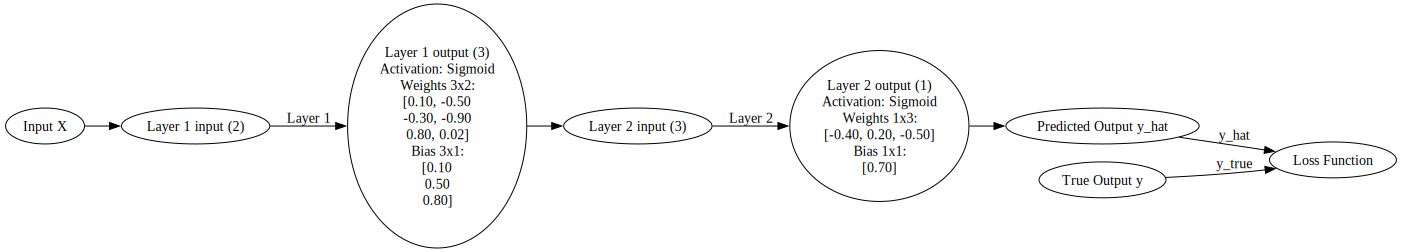

In [101]:
dot = generate_mlp_graph(mlp)
#dot.render('mlp_graph', format='png', view=True) 
display(dot)